## Setup

In [1]:
!pip install yfinance
!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.1.0
Uninstalling gdown-5.1.0:
  Successfully uninstalled gdown-5.1.0
gdown 5.2.0 at /usr/local/lib/python3.10/dist-packages


In [2]:
!gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/

Downloading...
From (original): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP
From (redirected): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP&confirm=t&uuid=195c7b7e-b304-4e76-bbca-9281ec620724
To: /content/stocks_df_combined_2024_05_07.parquet.brotli
100% 119M/119M [00:07<00:00, 16.7MB/s]


In [3]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score

In [4]:
df_full = pd.read_parquet("/content/stocks_df_combined_2024_05_07.parquet.brotli", )

In [5]:
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']
TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]

In [6]:
df_full.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,1980-12-12,2024-05-07,10941
ACN,2001-07-19,2024-05-07,5736
AMZN,1997-05-15,2024-05-07,6789
ASML,1995-03-15,2024-05-07,7338
AVGO,2009-08-06,2024-05-07,3713
BHARTIARTL.NS,2002-07-01,2024-05-07,5424
BRK-B,1996-05-09,2024-05-07,7046
CDI.PA,1992-01-27,2024-05-07,8328
GOOG,2004-08-19,2024-05-07,4963


In [7]:
df = df_full[df_full.Date>='2000-01-01']

### Question 1 (1 point): Dummies on Month and Week-of-Month

**Find the ABSOLUTE CORRELATION VALUE of the most correlated dummy <month-week_of_month> with the binary outcome variable `is_positive_growth_5d_future`?**

You saw in the correlation analysis and modeling that September and October may be important seasonal months. In this task, we'll go futher and try to generate dummies for Month and Week-of-month (starting from 1). For example, the first week of October should be coded similar to this: 'October_w1'.
Once you've generated the new set of variables, find the most correlated (in absolute value) one with `is_positive_growth_5d_future` and round it to 3 digits after the comma.

Suggested path to a solution:
- [[Source](https://stackoverflow.com/questions/25249033/week-of-a-month-pandas)] Use this formula to get the week of month for the datetime variable d: `(d.day-1)//7+1`
- Define a new string variable for all month-week_of_month combinations. Append it to the CATEGORICAL features set. You should have 5 variables treated as CATEGORICAL now: 'Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom'. In the end, you should get 115 dummy features, including 60 (=12*5) week_month_of_week dummies.
- Use [pandas.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to generate dummies.
- Use [pandas.DataFrame.corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) function (also used in [Code Snippet 1]) to get correlations with `is_positive_growth_5d_future`, filter out only variables representing the new dummy set, and sort it by absolute values (you can define a new column "abs_corr" in the dataframe with correlations), and find the highest value (among the new dummies features set).

**NOTE**: new dummies will be used as features in the next tasks, please leave them in the dataset.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df['Month'] = df['Date'].dt.month_name()
df['Week_of_Month'] = ((df['Date'].dt.day - 1) // 7 + 1).astype(str)
df['month_wom'] = df['Month'] + '_w' + df['Week_of_Month']

<ipython-input-8-0a5124f841c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-8-0a5124f841c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Date'].dt.month_name()
<ipython-input-8-0a5124f841c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
categorical_features = ['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

corrs = df.corr()['is_positive_growth_5d_future'].drop('is_positive_growth_5d_future')

month_wom_dummies = [col for col in df.columns if 'month_wom_' in col]
corrs = corrs[month_wom_dummies]

corrs_abs = corrs.abs()

max_corr_value = round(corrs_abs.max(), 3)
most_correlated_dummy = corrs_abs.idxmax()

print(f"The most correlated dummy variable is: {most_correlated_dummy}")
print(f"The absolute correlation value is: {max_corr_value}")

The most correlated dummy variable is: month_wom_September_w3
The absolute correlation value is: 0.035


### Question 2 (2 points): Define new "hand" rules on macro and technical indicators variables

**What is the precision score for the best of the NEW predictions (pred3 or pred4), rounded to 3 digits after the comma?**

Let's utilize the knowledge from the visualised tree (clf10) (Code Snippet 5: 1.4.4 Visualisation):

* You're asked to define two new 'hand' rules (leading to 'positive' subtrees):
  - `pred3_manual_gdp_fastd`: (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
  - `pred4_manual_gdp_wti_oil`: (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)

* Extend the Code Snippet 3 (Manual "hand rule" predictions): Calculate and add new rules (pred3 and pred4) to the dataframe.You should notice that one of the predictions doesn't have any positive predictions on TEST dataset (while it has many on TRAIN+VALIDATION).

* Debug: check in the `new_df` and the original dataset/data generation process that we didn't make any mistakes during the data transformation step.

* Explain why this can happen even if there are no errors in the data features.

* As a result, write down the precision score for the remaining predictor (round to three decimal points). E.g. if you have 0.57897, your answer should be 0.579.

In [12]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [13]:
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

In [14]:
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [15]:
DUMMIES = dummy_variables.keys().to_list()
df_with_dummies = pd.concat([df, dummy_variables], axis=1)
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 239 entries, growth_1d to ticker_type_US
dtypes: float64(121), int32(117), int64(1)
memory usage: 253.0 MB


In [16]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [17]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.675834
test          0.163290
validation    0.160876
Name: count, dtype: float64

In [18]:
new_df = df_with_dummies.copy()

In [ ]:
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_1d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_1d'] > 1) & (new_df['growth_snp500_1d'] > 1)).astype(int)

In [ ]:
new_df['pred3_manual_gdp_fastd'] = ((new_df['gdppot_us_yoy'] <= 0.027) & (new_df['fastd'] >= 0.251)).astype(int)
new_df['pred4_manual_gdp_wti_oil'] = ((new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)).astype(int)

In [ ]:
precision_pred0 = precision_score(new_df['is_positive_growth_5d_future'], new_df['pred0_manual_cci'])
precision_pred1 = precision_score(new_df['is_positive_growth_5d_future'], new_df['pred1_manual_prev_g1'])
precision_pred2 = precision_score(new_df['is_positive_growth_5d_future'], new_df['pred2_manual_prev_g1_and_snp'])
precision_pred3 = precision_score(new_df['is_positive_growth_5d_future'], new_df['pred3_manual_gdp_fastd'])
precision_pred4 = precision_score(new_df['is_positive_growth_5d_future'], new_df['pred4_manual_gdp_wti_oil'])

In [ ]:
print("Precision Scores:")
print(f"\tpred0_manual_cci: {precision_pred0:.3f}")
print(f"\tpred1_manual_prev_g1: {precision_pred1:.3f}")
print(f"\tpred2_manual_prev_g1_and_snp: {precision_pred2:.3f}")
print(f"\tpred3_manual_gdp_fastd: {precision_pred3:.3f}")
print(f"\tpred4_manual_gdp_wti_oil: {precision_pred4:.3f}")

Precision Scores:
	pred0_manual_cci: 0.539
	pred1_manual_prev_g1: 0.538
	pred2_manual_prev_g1_and_snp: 0.542
	pred3_manual_gdp_fastd: 0.552
	pred4_manual_gdp_wti_oil: 0.537


In [ ]:
new_df['pred3_manual_gdp_fastd']

3490    0
3491    0
3492    0
3493    0
3494    0
       ..
5422    1
5423    1
5424    1
5425    1
5426    1
Name: pred3_manual_gdp_fastd, Length: 182675, dtype: int64

#### pred3_manual_gdp_fastd
Rare Combination in Test Data. It's possible that the combination of low US GDP potential growth and high FastD is very rare in the test dataset. If most data points in the test set have either high GDP potential growth or low FastD, the condition would almost never be met, resulting in no positive predictions.



### Question 3 (1 point): Unique correct predictions from a 10-levels deep Decision Tree Classifier (pred5_clf_10)

**What is the total number of records in the TEST dataset when the new prediction pred5_clf_10 is better than all 'hand' rules (pred0..pred4)?**

NOTE: please include `random_state=42` to Decision Tree Classifier init function (line `clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)`) to ensure everyone gets the same results.

Suggested solution:
* Step1: Rewrite the '1.4.3 Inference for a decision tree' piece for the Decision Tree Classifier with max_depth=10 (clf_10), so that you fit the model on TRAIN+VALIDATION sets (unchanged from the lecture), but predict on the whole set X_all (to be able to define a new column 'pred5_clf_10' in the dataframe new_df). Here is the [link](https://stackoverflow.com/questions/40729162/merging-results-from-model-predict-with-original-pandas-dataframe) with explanation. It will solve the problem in 1.4.5 when predictions were made only for Test dataset and couldn't be easily joined with the full dataset.

* Step2: Once you have it, define a new column 'only_pred5_is_correct' similar to 'hand' prediction rules with several conditions: is_positive_growth_5d_future AND is_correct_pred5 should be equal 1, while all other predictions is_correct_pred0..is_correct_pred4 should be equal to 0.

* Step3: Convert 'only_pred5_is_correct' column from bool to int, and find how many times it is equal to 1 in the TEST set. Write down this as an answer.

ADVANCED: define a function that can be applied to the whole row of predictions ([a few examples of pandas-apply-row-functions](https://sparkbyexamples.com/pandas/pandas-apply-function-to-every-row/)) and can find whether some prediction 'predX' (where X is one of the predictions) is uniquely correct. It should work even if there are 100 predictions available, so that you don't define manually the condition for 'predX'.  

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import numpy as np

In [9]:
def remove_infinite_values(X):
    """
    Remove infinite values from the input array.

    Parameters:
    - X: Input array (NumPy array or array-like)

    Returns:
    - Array with infinite values removed
    """
    return X[np.isfinite(X).all(axis=1)]

In [10]:
def remove_outliers_percentile(X, lower_percentile=1, upper_percentile=99):
    """
    Remove outliers from the input array based on percentiles.

    Parameters:
    - X: Input array (NumPy array or array-like)
    - lower_percentile: Lower percentile threshold (float, default=1)
    - upper_percentile: Upper percentile threshold (float, default=99)

    Returns:
    - Array with outliers removed
    """
    lower_bound = np.percentile(X, lower_percentile, axis=0)
    upper_bound = np.percentile(X, upper_percentile, axis=0)
    mask = np.logical_and(np.all(X >= lower_bound, axis=1), np.all(X <= upper_bound, axis=1))
    return X[mask]

In [19]:
features_list = NUMERICAL+DUMMIES
to_predict = 'is_positive_growth_5d_future'

train_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
# need Date and Ticker later when merging predictions to the dataset
X_train = train_df[features_list+[to_predict,'Date','Ticker']]
X_test = test_df[features_list+[to_predict,'Date','Ticker']]

print(f'length: X_train {X_train.shape},  X_test {X_test.shape}')

length: X_train (152846, 242),  X_test (29829, 242)


In [20]:
pd.options.mode.chained_assignment = None  # default='warn'

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Need to fill NaNs somehow
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

print(f'length: X_train_imputed {X_train.shape},  X_test_imputed {X_test.shape}')

length: X_train_imputed (152846, 242),  X_test_imputed (29829, 242)


In [21]:
X_train_imputed = X_train # we won't use outliers removal to save more data to train: remove_outliers_percentile(X_train)
X_test_imputed = X_test # we won't use outliers removal to save more data to test: remove_outliers_percentile(X_test)

In [22]:
print(f'length: X_train_imputed {X_train_imputed.shape},  X_test_imputed {X_test_imputed.shape}')

length: X_train_imputed (152846, 242),  X_test_imputed (29829, 242)


In [23]:
y_train = X_train_imputed[to_predict]
y_test = X_test_imputed[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_imputed[to_predict]
del X_test_imputed[to_predict]

In [24]:
# estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [ ]:
clf_10, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=10)

In [28]:
def predict_decision_tree(clf:DecisionTreeClassifier, df_X:pd.DataFrame, y_true: pd.Series):
  # Predict the target variable on the test data
  y_pred = clf.predict(df_X)

  max_depth = clf.tree_.max_depth
  # Print the maximum depth
  print("Maximum depth of the decision tree:", max_depth)

  # Calculate the accuracy/precision of the model
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  print(f'Accuracy ={accuracy}, precision = {precision}')

  # resulting df
  result_df = pd.concat([df_X, y_true, pd.Series(y_pred, index=df_X.index, name='pred_')], axis=1)

  return result_df, accuracy, precision

In [ ]:
X_all= pd.concat([X_train_imputed, X_test_imputed], ignore_index=True)

In [ ]:
y_all = pd.concat([y_train, y_test], axis=0)

In [ ]:
pred10_test = predict_decision_tree(clf_10, X_test_imputed.drop(['Date','Ticker'],axis=1), y_test)

Maximum depth of the decision tree: 10
Accuracy =0.5572429514901606, precision = 0.5652630759651308


In [ ]:
X_all['pred5_clf_10'] = clf_10.predict(X_all.drop(['Date','Ticker'],axis=1))
X_all['pred0_manual_cci'] = (X_all.cci>200).astype(int)
X_all['pred1_manual_prev_g1'] = (X_all.growth_1d>1).astype(int)
X_all['pred2_manual_prev_g1_and_snp'] = ((X_all['growth_1d'] > 1) & (X_all['growth_snp500_1d'] > 1)).astype(int)
X_all['pred3_manual_gdp_fastd'] = ((X_all['gdppot_us_yoy'] <= 0.027) & (X_all['fastd'] >= 0.251)).astype(int)
X_all['pred4_manual_gdp_wti_oil'] = ((X_all['gdppot_us_yoy'] >= 0.027) & (X_all['growth_wti_oil_30d'] <= 1.005)).astype(int)

In [ ]:
length_train = len(X_train_imputed)
X_all['split'] = ['train' if i < length_train else 'test' for i in X_all.index]
X_all['is_positive_growth_5d_future'] =list(y_all)

In [ ]:
pred_all=X_all[['is_positive_growth_5d_future','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_gdp_fastd','pred4_manual_gdp_wti_oil','pred5_clf_10','split']]

In [ ]:
pred_all['only_pred5_is_correct'] = (
    (pred_all['pred5_clf_10'] == pred_all['is_positive_growth_5d_future']) &
    (pred_all['pred0_manual_cci'] != pred_all['is_positive_growth_5d_future']) &
    (pred_all['pred1_manual_prev_g1'] != pred_all['is_positive_growth_5d_future']) &
    (pred_all['pred2_manual_prev_g1_and_snp'] != pred_all['is_positive_growth_5d_future']) &
    (pred_all['pred3_manual_gdp_fastd'] != pred_all['is_positive_growth_5d_future']) &
    (pred_all['pred4_manual_gdp_wti_oil'] != pred_all['is_positive_growth_5d_future'])
)

In [ ]:
pred_all['only_pred5_is_correct'] = pred_all['only_pred5_is_correct'].astype(int)

In [ ]:
pred_all[pred_all['split'] == 'test']['only_pred5_is_correct'].sum()

1

### Question 4: (2 points) Hyperparameter tuning for a Decision Tree

**What is the optimal tree depth (from 1 to 20) for a DecisionTreeClassifier?**

NOTE: please include `random_state=42` to Decision Tree Classifier init function (line `clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)`) to ensure consistency in results.

Follow these steps to find the optimal `max_depth`:
* Iterate through `max_depth` values from 1 to 20.
* Train the Decision Tree Classifier with the current `max_depth` parameter.
* Optionally, visualize how the 'head' of each fitted tree changes with more advanced (=deep) trees. You can use the [`sklearn.tree.plot_tree()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function, or the compact way  with the `export_text()` functionality ([Stack Overflow example](https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn)):
  ```
  from sklearn.tree import export_text
  tree_rules = export_text(model, feature_names=list(X_train), max_depth=3)
  print(tree_rules)
  ```
* Calculate the precision score (you can use the function [sklearn.metrics.precision_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)) on the TEST dataset for each of the fitted trees. You can also compare it with the precision score on a VALIDATION dataset, which is included to the training phase (to have more data to train on). You should see that the precision score on a VALIDATION set starts to grow with the complexity of a tree (overfit), which isn't seen on the precision score on TEST.
* Identify the optimal `max_depth`, where the  precision score is the highest on the TEST dataset. Record this value as  **best_max_depth** and submit as an answer.
* Make predictions on all records (TRAIN+VALIDATION+TEST) and add the new prediction `pred6_clf_best` to the dataframe `new_df`.

Additionally, compare the precision score of the tuned decision tree with previous predictions. You should observe an improvement (>0.58, or more than 58% precision), indicating that the tuned tree outperforms previous manual "hand" rules and Decision Tree predictions.

ADVANCED: Read more about different aspects of [scikit-learn Decision Trees](https://scikit-learn.org/stable/modules/tree.html). Draw a line of precision/accuracy vs. max_depth and note whether there's a saturation point of precision/accuracy as max_depth increases. In theory, there should be a trade-off between better fitting (=more complex trees) and generalization.

In [26]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, precision_score

In [29]:
accuracies = []
precisions = []
depths = []

# Iterate over max_depth from 1 to 20
for depth in range(1, 21):
    clf, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date', 'Ticker'], axis=1), y=y_train, max_depth=depth)
    pred_df, accuracy, precision = predict_decision_tree(clf, X_test_imputed.drop(['Date', 'Ticker'], axis=1), y_test)

    # Store results
    depths.append(depth)
    accuracies.append(accuracy)
    precisions.append(precision)

    # Print the rules of the decision tree for the first 3 levels
    tree_rules = export_text(clf, feature_names=list(train_columns), max_depth=3)
    print(f"Tree rules for max_depth={depth}:\n", tree_rules)

Maximum depth of the decision tree: 1
Accuracy =0.5551979617151095, precision = 0.5551979617151095
Tree rules for max_depth=1:
 |--- gdppot_us_yoy <= 0.03
|   |--- class: 1
|--- gdppot_us_yoy >  0.03
|   |--- class: 0

Maximum depth of the decision tree: 2
Accuracy =0.5553655838278185, precision = 0.5552947488431359
Tree rules for max_depth=2:
 |--- gdppot_us_yoy <= 0.03
|   |--- fastd <= 0.25
|   |   |--- class: 0
|   |--- fastd >  0.25
|   |   |--- class: 1
|--- gdppot_us_yoy >  0.03
|   |--- growth_wti_oil_30d <= 1.00
|   |   |--- class: 1
|   |--- growth_wti_oil_30d >  1.00
|   |   |--- class: 0

Maximum depth of the decision tree: 3
Accuracy =0.5551979617151095, precision = 0.5551979617151095
Tree rules for max_depth=3:
 |--- gdppot_us_yoy <= 0.03
|   |--- fastd <= 0.25
|   |   |--- growth_brent_oil_90d <= 1.06
|   |   |   |--- class: 0
|   |   |--- growth_brent_oil_90d >  1.06
|   |   |   |--- class: 1
|   |--- fastd >  0.25
|   |   |--- growth_gold_365d <= 1.53
|   |   |   |--- 

In [30]:
results_df = pd.DataFrame({
    'max_depth': depths,
    'accuracy': accuracies,
    'precision': precisions
})

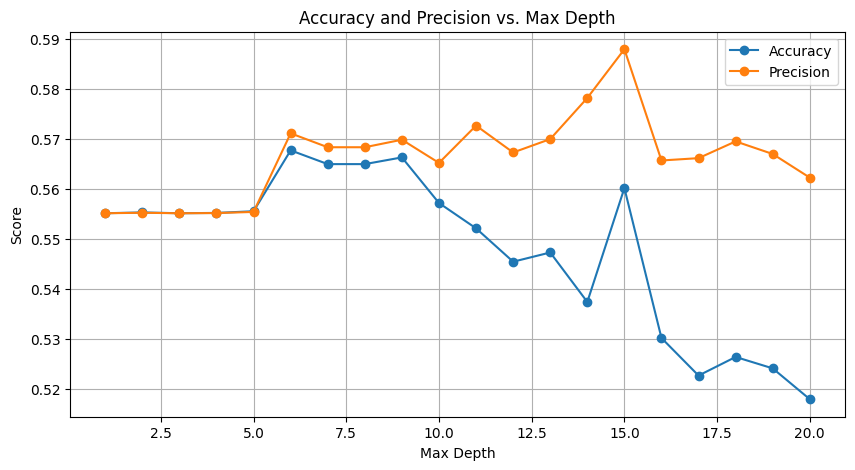

In [31]:
plt.figure(figsize=(10, 5))

plt.plot(results_df['max_depth'], results_df['accuracy'], label='Accuracy', marker='o')
plt.plot(results_df['max_depth'], results_df['precision'], label='Precision', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Accuracy and Precision vs. Max Depth')
plt.legend()
plt.grid(True)
plt.show()

### [EXPLORATORY] Question 5: What data is missing?

Now that you have some insights from the correlation analysis and the Decision Trees regarding the most influential variables, suggest new indicators you would like to include in the dataset and explain why.

You can also propose something entirely different based on your intuition, but it should be relevant to the shared dataset of the largest Indian, EU, and US stocks. If you choose this approach, please specify the data source as well.